In [19]:
!pip install openai
!pip install yfinance
!pip install mplfinance
import mplfinance as mpf
from openai import OpenAI, OpenAIError
import yfinance as yf
import pandas as pd #
import datetime as dt

In [20]:
stock_id = "META"
end = dt.date.today() # end time
start = end - dt.timedelta(days =180) # start time
StockData = yf.download(stock_id, start , end).reset_index()


[*********************100%%**********************]  1 of 1 completed


Use OpenAI to write calculate function

In [21]:
import getpass
api_key = ""
client = OpenAI(api_key = api_key)

In [22]:
def get_reply(messages):
  try:
    response = client.chat.completions.create(model="gpt-3.5-turbo", messages=messages)
    reply = response.choices[0].message.content
  except OpenAIError as err:
    reply = f"發生 {err.type} 錯誤\n{err.message}"
  return reply
def ai_helper(StockData, user_msg):
  msg = [{"role":"system","content":
      f"I require your assistance in generating Python code based on specific user requirements.\
      Your need to carefully analyze user's requirements and generate the Python code.\
      I will provide you with a dataframe (StockData) that follows the format {StockData.columns}.\
      Please note that your response should solely consist of the code itself,and no additional information should be included."},
      {"role":"user","content":
      f"The user requirement:{user_msg} \n\
      Your task is to develop a Python function named \
      'calculate(StockData)'. This function should accept a dataframe as \
      its parameter. Ensure that you only utilize the columns \
      present in the dataset, specifically {StockData.columns}. \
      After processing, the function should return the processed \
      dataframe. Your response should strictly contain the Python \
      code for the 'calculate(StockData)' function \
      and exclude any unrelated content."
      }]
  reply_data = get_reply(msg)
  cleaned_code = reply_data.replace("```","")
  cleaned_code = cleaned_code.replace("python","")

  return cleaned_code

In [23]:
code_str = ai_helper(StockData,"1. calculate MACD and named it as MACD_Histogram, 2. Calculating Bollinger Bands and named it as Upper_Band and Lower_Band")
# customize your need
print(code_str)
exec(code_str)
new_StockData = calculate(StockData) ## AI generated code
new_StockData.tail()

def calculate(StockData):
    StockData['MACD_Histogram'] = StockData['Close'].ewm(span=12, adjust=False).mean() - StockData['Close'].ewm(span=26, adjust=False).mean()
    StockData['MA20'] = StockData['Close'].rolling(window=20).mean()
    StockData['20 Day STD'] = StockData['Close'].rolling(window=20).std()
    StockData['Upper_Band'] = StockData['MA20'] + (StockData['20 Day STD'] * 2)
    StockData['Lower_Band'] = StockData['MA20'] - (StockData['20 Day STD'] * 2)
    
    return StockData


,Date,Open,High,Low,Close,Adj Close,Volume,MACD_Histogram,MA20,20 Day STD,Upper_Band,Lower_Band
117,2024-06-14,502.649994,507.149994,500.750000,504.160004,504.160004,10243300,8.621041,483.437498,15.859020,515.155539,451.719458
118,2024-06-17,501.670013,510.750000,496.010010,506.630005,506.630005,11266600,8.929737,485.173499,16.421099,518.015696,452.331301
119,2024-06-18,504.559998,506.000000,495.019989,499.489990,499.489990,13060400,8.500255,486.705998,16.245817,519.197632,454.214365
120,2024-06-20,502.000000,503.670013,496.769989,501.700012,501.700012,11801200,8.243196,488.559499,15.700094,519.959688,457.159310
121,2024-06-21,503.450012,503.450012,492.390015,494.779999,494.779999,22359200,7.395832,489.909499,14.962802,519.835102,459.983895


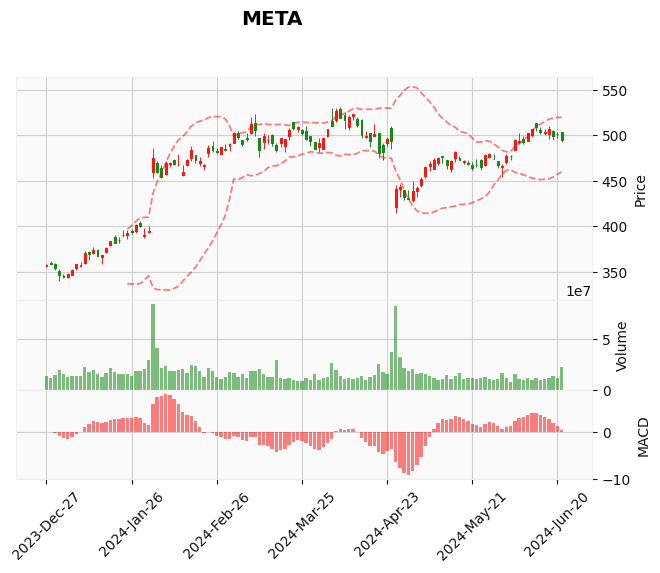

In [ ]:
kplot_StockData = new_StockData.set_index('Date')
end = dt.date.today() # end time
start = end - dt.timedelta(days =180) # start time
kplot_StockData = kplot_StockData[start:end]
kplot_StockData.tail()
# set drawing style
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='yahoo',marketcolors=my_color)

ap = [
mpf.make_addplot(kplot_StockData['Upper_Band'], color='red',alpha=0.5, linestyle='--'),
mpf.make_addplot(kplot_StockData['Lower_Band'], color='red',alpha=0.5, linestyle='--'),
mpf.make_addplot(kplot_StockData['Volume'], panel=1, type='bar',color='g', alpha=0.5, ylabel='Volume'),
mpf.make_addplot(kplot_StockData['MACD_Histogram'], panel=2, type='bar',color='r', alpha=0.5, ylabel='MACD')]
mpf.plot(kplot_StockData, type='candle', addplot=ap,style=my_style, title=f'{stock_id}')